In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.optimize
import sklearn.decomposition
import sklearn.manifold

# 0 Demo code
## 0.0 Import and plot a dataset

We'll use the same dataset as in lecture 1, the World Bank dataset of statistics about states.

In [7]:
countries = pandas.read_csv('lecture1-introduction/data/country-stats.csv')
countries.iloc[:3]

,Country Name,GDP per Capita (PPP USD),Population Density (persons per sq km),Population Growth Rate (%),Urban Population (%),Life Expectancy at Birth (avg years),Fertility Rate (births per woman),Infant Mortality (deaths per 1000 births),"Enrolment Rate, Tertiary (%)","Unemployment, Total (%)",Estimated Control of Corruption (scale -2.5 to 2.5),Estimated Government Effectiveness (scale -2.5 to 2.5),Internet Users (%)
0,Afghanistan,1560.67,44.62,2.44,23.86,60.07,5.39,71.0,3.33,8.5,-1.41,-1.40,5.45
1,Albania,9403.43,115.11,0.26,54.45,77.16,1.75,15.0,54.85,14.2,-0.72,-0.28,54.66
2,Algeria,8515.35,15.86,1.89,73.71,70.75,2.83,25.6,31.46,10.0,-0.54,-0.55,15.23


Plot a splom. There's lots of messy matplotlib code to make plots look nice, and it calls for frequent use of stackoverflow.

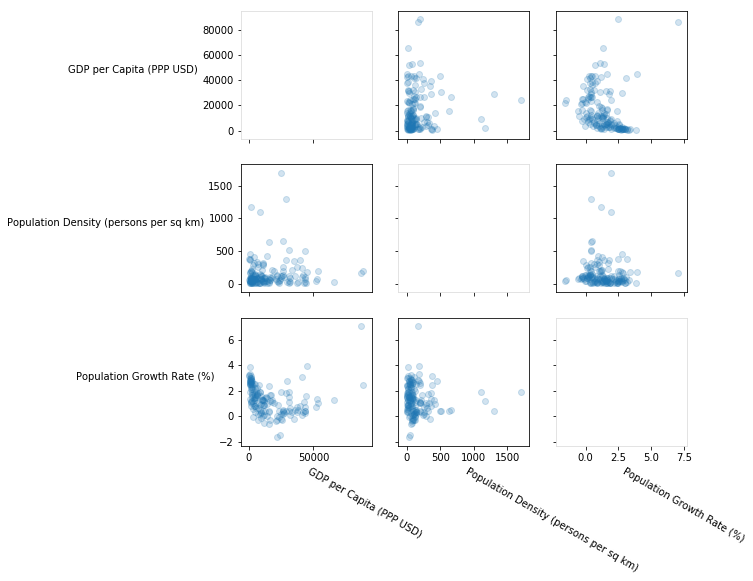

In [9]:
# Pick out the first three columns, excluding "Country Name", to show in the splom
features = countries.columns[1:4]

with plt.rc_context({'figure.figsize': (8,8)}):
    fig,ax = plt.subplots(len(features), len(features), sharex='col', sharey='row')
    for i,c in enumerate(features):
        for j,d in enumerate(features):
            if i == j:
                for child in ax[i,j].get_children():
                    if isinstance(child, matplotlib.spines.Spine):
                        child.set_color('#dddddd')
            if i != j:
                ax[i,j].scatter(countries[d], countries[c], alpha=.2)
    for i,c in enumerate(features):
        ax[i,0].set_ylabel(c, rotation=0, horizontalalignment='right')
    for j,d in enumerate(features):
        ax[len(features)-1,j].set_xlabel(d, rotation=-30, ha='left')
plt.show()

## 0.1 One-dimensional PCA

Here is an entirely manual version of one-dimensional PCA. You never need to code PCA yourself, since there are much more efficient libraries to do it for you, but it's useful to see how little there is to it. If you want to build fancier algorithms for dimension reduction, such as autoencoders, you'll have to code similar steps to these, perhaps implementing them in TensorFlow.

Optimization terminated successfully.
         Current function value: 225.098938
         Iterations: 44
         Function evaluations: 85


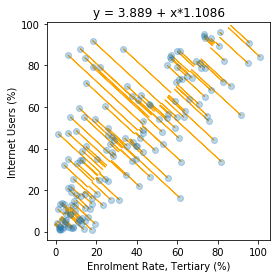

In [14]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'

# We'll look for a straight line fit   y = m*x + c.
# This isn't the best parameterization (it can't represent a vertical line), but it's simple
# and sufficient for this problem.

def proj(x, y, θ):
    # Given vectors x and y, project them onto the line θ=(m,c)
    m,c = θ
    y0,dx,dy = c,1,m
    d = np.sqrt(dx**2 + dy**2)
    dx,dy = dx/d, dy/d
    dot = x*dx + (y-y0)*dy
    return dot*dx, y0 + dot*dy

def err(θ):
    # Given straight-line parameters θ=(m,c), find the mean square error of all the projections
    px,py = proj(countries[fx], countries[fy], θ)
    ex,ey = countries[fx]-px, countries[fy]-py
    return np.mean(ex**2 + ey**2)

# Run an optimizer to find the error-minimizing parameters.
# Here I'm using the built in scipy.optimize.fmin.
# You could also implement this with gradient descent.

m,c = scipy.optimize.fmin(err, x0=[.9,10])

# Project the data onto the fitted straight line
predx,predy = proj(countries[fx], countries[fy], (m,c))

with plt.rc_context({'figure.figsize': (4,4)}):
    fig,ax = plt.subplots()
    ax.scatter(countries[fx], countries[fy], alpha=.3)
    for x,y,px,py in zip(countries[fx], countries[fy], predx, predy):
        ax.arrow(x,y, px-x,py-y, color='orange', zorder=-1)
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)
plt.title(f"y = {c:.5} + x*{m:.5}")
plt.show()

Here's the same model, fitted using the PCA library function.

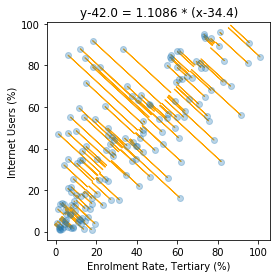

In [13]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'
X = countries[[fx,fy]].values

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# Find the predictions from the PCA model, using just the first component
μx,μy = pca.mean_
δx,δy = pca.components_[0]
λ = pca_result[:,0]
predx,predy = μx+λ*δx, μy+λ*δy

with plt.rc_context({'figure.figsize': (4,4)}):
    fig,ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], alpha=.3)
    for x,y,px,py in zip(X[:,0], X[:,1], predx, predy):
        ax.arrow(x,y, (px-x),py-y, color='orange', zorder=-1)
    ax.set_xlabel(fx)
    ax.set_ylabel(fy)
plt.title(f"y-{μy:.3} = {δy/δx:.5} * (x-{μx:.3})")
plt.show()

## 0.2 Full PCA

Here is the full PCA, run on the entire set of features. 

PCA looks for a good approximation to your dataset, and it treats an error of size $e$ in one feature as just as serious as an error of size $e$ in any other feature. It's therefore wise to scale the features appropriately. If you don't have any real insight into how you should weight them, then just make all your columns have the same variance.

This code fits the model
$$
x_i = \mu + \sum_{k=1}^K \lambda_{k,i} \delta_k
$$
where $K$ is the number of features, and $\mu$, $x_i$, and $\delta_k$ are all $K$-dimensional vectors. It organizes the components $\delta_k$ so that the most important comes first, i.e. so that if you want to approximate the data using only $L<K$ components then you should use the first $L$,
$$
x_i \approx \mu + \sum_{k=1}^L \lambda_{k,i} \delta_k
$$

In [21]:
# drop the column 'Country Name', which isn't numeric
features = countries.columns[1:]
X = countries[features].values

# rescale the features, so they have the same variance
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# how the results are returned
print("μ:", pca.mean_)
k,i = 2,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [9.54780563e-01 6.59481318e-01 1.16550076e+00 2.43443295e+00
 8.06247583e+00 1.98804330e+00 1.05052397e+00 1.28125213e+00
 1.22381235e+00 7.32740877e-03 5.19484572e-02 1.45502392e+00]
δ[k=2]: [-0.21521157  0.81173439 -0.18916308 -0.21801048  0.13379205 -0.19250245
 -0.13653149 -0.08295349 -0.30953473 -0.1667017  -0.06814961 -0.05229533]
λ[k=2,i=10]: 4.650211499899456


PCA gives us a nice way to summarize a large number of features in two dimensions.

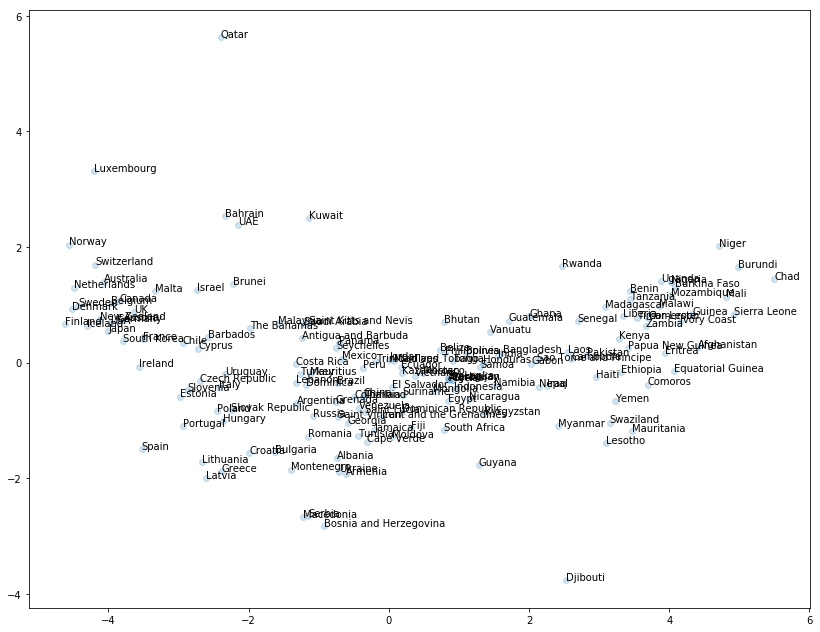

In [23]:
p1,p2 = pca_result[:,0], pca_result[:,1]

with plt.rc_context({'figure.figsize': (14,11)}):
    plt.scatter(p1, p2, alpha=.2)
    for x,y,s in zip(p1,p2,countries['Country Name']):
        plt.text(x,y,s)
plt.show()

## 0.3 t-SNE

t-SNE is another tool for dimension reduction. You have to tell it how many components you want it to produce (unlike PCA, which produces all components and then it's up to you how many to use).

In [24]:
# use all the numerical features, and drop the column 'Country Name'
features = countries.columns[1:]

# as with PCA, we should be careful about the scale of data we present to the algorithm
X = countries[features].values
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])
    
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 161 samples in 0.013s...
[t-SNE] Computed neighbors for 161 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 161 / 161
[t-SNE] Mean sigma: 1.399072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.349052
[t-SNE] Error after 950 iterations: 0.362750


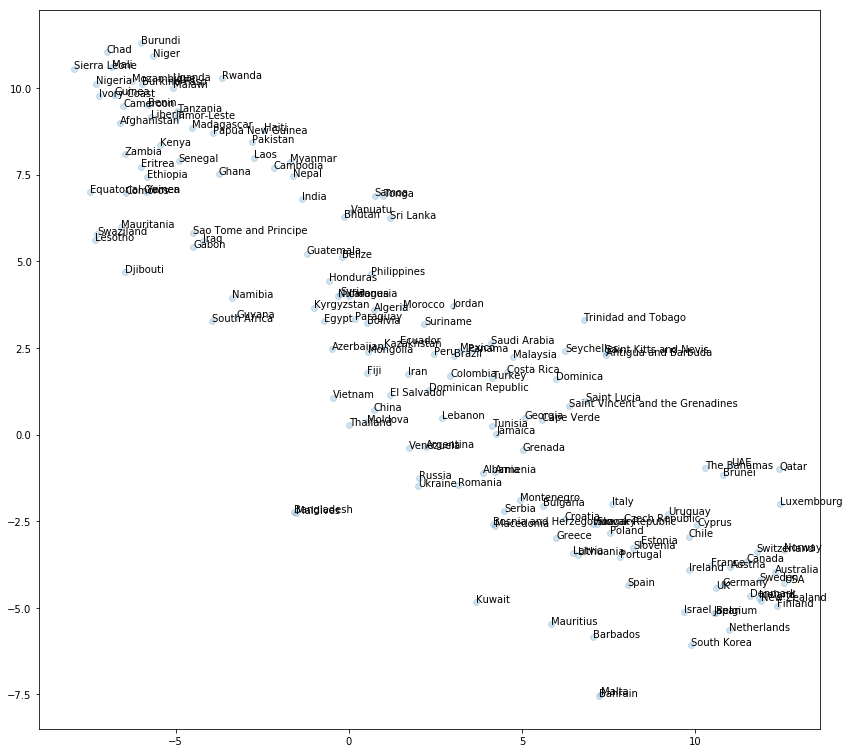

In [29]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]

with plt.rc_context({'figure.figsize': (14,14)}):
    plt.scatter(p1, p2, alpha=.2)
    for x,y,s in zip(p1,p2,countries['Country Name']):
        plt.text(x,y,s)
# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
plt.gca().set_aspect('equal')
plt.show()

<div style="height: 15em"></div>

# 1. Assignment

<div style="size:200%; color:red">DRAFT. Final version will be uploaded by 5pm on 2018-11-23.</div>

In this assignment, you will use dimension reduction to visualize the California housing dataset. And you will evaluate the accuracy of the dimension reduction.

In [59]:
housing = pandas.read_csv('DSPNP_practical1/housing/housing.csv')

features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

**Question 1.** Use principal components analysis on the above features. You should scale the features appropriately. Plot a scatter plot of the first two components, and colour-code the points by `ocean_proximity`.

Hint. A quick and dirty way to colour-code a scatter plot in `matplotlib` is by
```
for lvl in distinct levels of some feature z:
    i = (z == lvl)
    plt.scatter(x[i], y[i], label=lvl)
plt.legend()
```

**Question 2.** Use t-SNE in the same way to question 1. For speed, you may like to restrict your attention to a random subset of rows for both question 1 and 2, rather than working with the full dataset.

**Question 3.** In the t-SNE plot in Section 0.3 above, why did I use `set_aspect('equal')`? Why didn't I choose to use it for the PCA plot?

**Question 4.** Run PCA, and let $\tilde{X}_L$ be the approximation to your feature matrix $X$ using only the first $L$ principal components, $L=0,\dots,K$ where $K$ is the number of features. Draw a bar chart with $L$ on the $x$-axis, and the mean square error of $X$ compared to $\tilde{X}_L$ on the $y$-axis.

**Question 5.** Use cross validation to decide how many principal components you should use to model the dataset.